# New Stellar Models - NGC 628

Fit NGC 628 with the new BPASS and PEGASE + Cloudy nebular models.

## Imports

In [1]:
import numpy as np
import h5py
rng = np.random.default_rng()
import astropy.units as u
from astropy.table import Table
from corner import corner
import matplotlib.pyplot as plt
plt.style.use('lightning.plots.style.lightning-serif')
%matplotlib inline

from lightning import Lightning
from lightning.priors import UniformPrior, NormalPrior, ConstantPrior

## Initialization

We'll use 7 SFH bins and the new BPASS + Cloudy models to start. Note that we have the option of whether or not we want to include dust grains in the nebular model. We're including them here, but this adds some age dependent attenuation (analogous to the old birth cloud attenuation) and an extra cold dust component to the "intrinsic" stellar spectrum.

In [2]:
cat = Table.read('../photometry/ngc628_dale17_photometry.fits')

# Housekeeping to load the photometry:
# strings come in as bytestrings (unencoded)
# The labels are also padded with spaces
filter_labels = np.array([s.decode().strip() for s in cat['FILTER_LABELS'].data[0]])
fnu_obs = cat['FNU_OBS'].data[0]
fnu_unc = cat['FNU_UNC'].data[0]
dl = cat['LUMIN_DIST'].data[0]

agebins = [0.0] + list(np.logspace(7, np.log10(13.4e9), 7))

lgh = Lightning(filter_labels, 
                lum_dist=dl, 
                ages=agebins,
                nebula_lognH=3.5,
                nebula_dust=True,
                stellar_type='BPASS-A24',
                SFH_type='Piecewise-Constant',
                atten_type='Modified-Calzetti',
                dust_emission=True,
                model_unc=0.10,
                print_setup_time=True)


lgh.flux_obs = fnu_obs * 1e3
lgh.flux_unc = fnu_unc * 1e3

# We could save the configuration like so:
# lgh.save_pickle('ngc628_BPASS_config.pkl')

0.024 s elapsed in _get_filters
0.001 s elapsed in _get_wave_obs
1.152 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
0.150 s elapsed in dust emission model setup
0.000 s elapsed in agn emission model setup
0.000 s elapsed in X-ray model setup
1.326 s elapsed total


In [3]:
lgh.print_params(verbose=True)


Piecewise-Constant
Parameter  Lo  Hi              Description
--------- --- --- ------------------------
    psi_1 0.0 inf SFR in stellar age bin 1
    psi_2 0.0 inf SFR in stellar age bin 2
    psi_3 0.0 inf SFR in stellar age bin 3
    psi_4 0.0 inf SFR in stellar age bin 4
    psi_5 0.0 inf SFR in stellar age bin 5
    psi_6 0.0 inf SFR in stellar age bin 6
    psi_7 0.0 inf SFR in stellar age bin 7

BPASS-Stellar-A24
Parameter                    Lo                 Hi                                                   Description
--------- --------------------- ------------------ -------------------------------------------------------------
     Zmet 0.0006471873203208087 0.0257649912911017 Metallicity (mass fraction, where solar = 0.020 ~ 10**[-1.7])
     logU                  -4.0               -1.5                             log10 of the ionization parameter

Modified-Calzetti
      Parameter   Lo                 Hi                                                                

In [4]:
p0_seed = np.array([5,5,5,0,0,0,0,
                    0.014, -2.0,
                    0.1, -1.0, 0.0,
                    2, 3, 3e5, 0.01, 0.02])

priors = 7 * [UniformPrior([0,20])] + \
             [NormalPrior([0.013, 0.001]), NormalPrior([-2.5,0.75])] + \
             [UniformPrior([0,3]), UniformPrior([-1.5, 0.3]), ConstantPrior([0.0])] + \
             [ConstantPrior([2.0]), UniformPrior([0.1, 25]), ConstantPrior([3e5]), UniformPrior([0,1]), UniformPrior([0.0047, 0.0458])]
const_dim = 7 * [False] + \
            [False, False] + \
            [False, False, True] + \
            [True, False, True, False, False]
const_dim = np.array(const_dim)
const_vals = p0_seed[const_dim]

Nwalkers = 64
# p0 = p0_seed[None, :] + rng.normal(loc=0, scale=1e-5, size=(Nwalkers, len(p0_seed)))
# p0[:, const_dim] = p0_seed[const_dim]

p0s = [pr.sample(Nwalkers) if pr is not None else np.zeros(Nwalkers) for pr in priors]
p0 = np.stack(p0s, axis=-1)
# Metallicity and logU have Normal priors and consequently might sample out 
# of the hard bounds on the parameters.
p0[p0[:,7] < 0.001, 7] = 0.001
p0[p0[:,7] > 0.02, 7] = 0.02
p0[p0[:,8] < -3, 8] = -3
p0[p0[:,8] > -1.5, 8] = -1.5


mcmc = lgh.fit(p0,
               method='emcee',
               priors=priors,
               const_dim=const_dim,
               Nwalkers=Nwalkers,
               Nsteps=30000,
               progress=True)

# mcmc = l.fit(p0, method='emcee', Nwalkers=Nwalkers, Nsteps=20000, priors=priors, const_dim=const_dim)
# print(res_bp)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [15:32<00:00, 32.15it/s]


In [5]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc.acceptance_fraction)))

MCMC mean acceptance fraction: 0.205


In [6]:
chain, logprob_chain, tau_ac = lgh.get_mcmc_chains(mcmc, discard=15000, thin=500, const_dim=const_dim, const_vals=p0_seed[const_dim])

         The autocorrelation estimate may be unreliable.


With this more complicated model `emcee` is going to recommend a longer chain, even beyond what we've already run.

## Plots

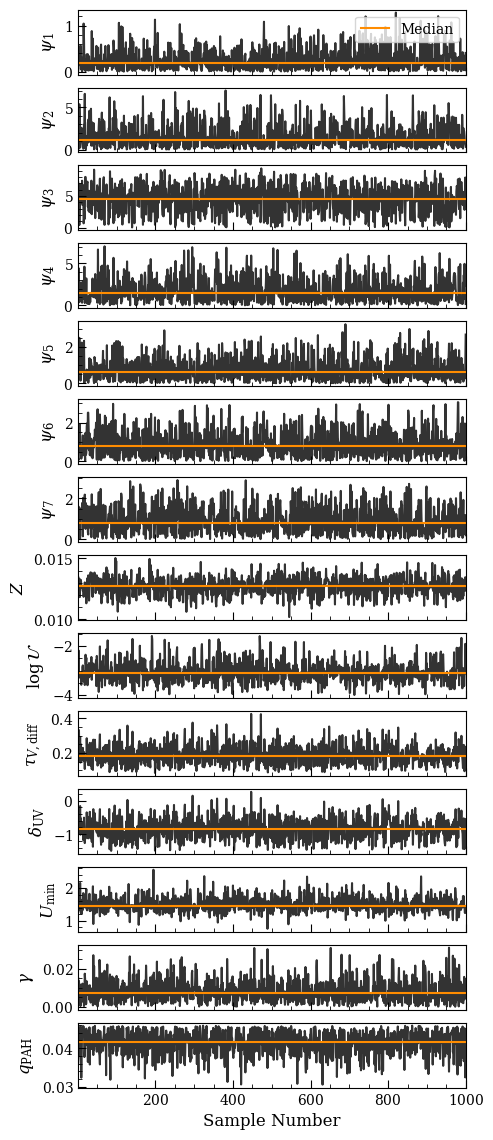

In [7]:
fig, axs = lgh.chain_plot(chain, color='k', alpha=0.8)

We'll plot the metallicity prior on top, just because we can:

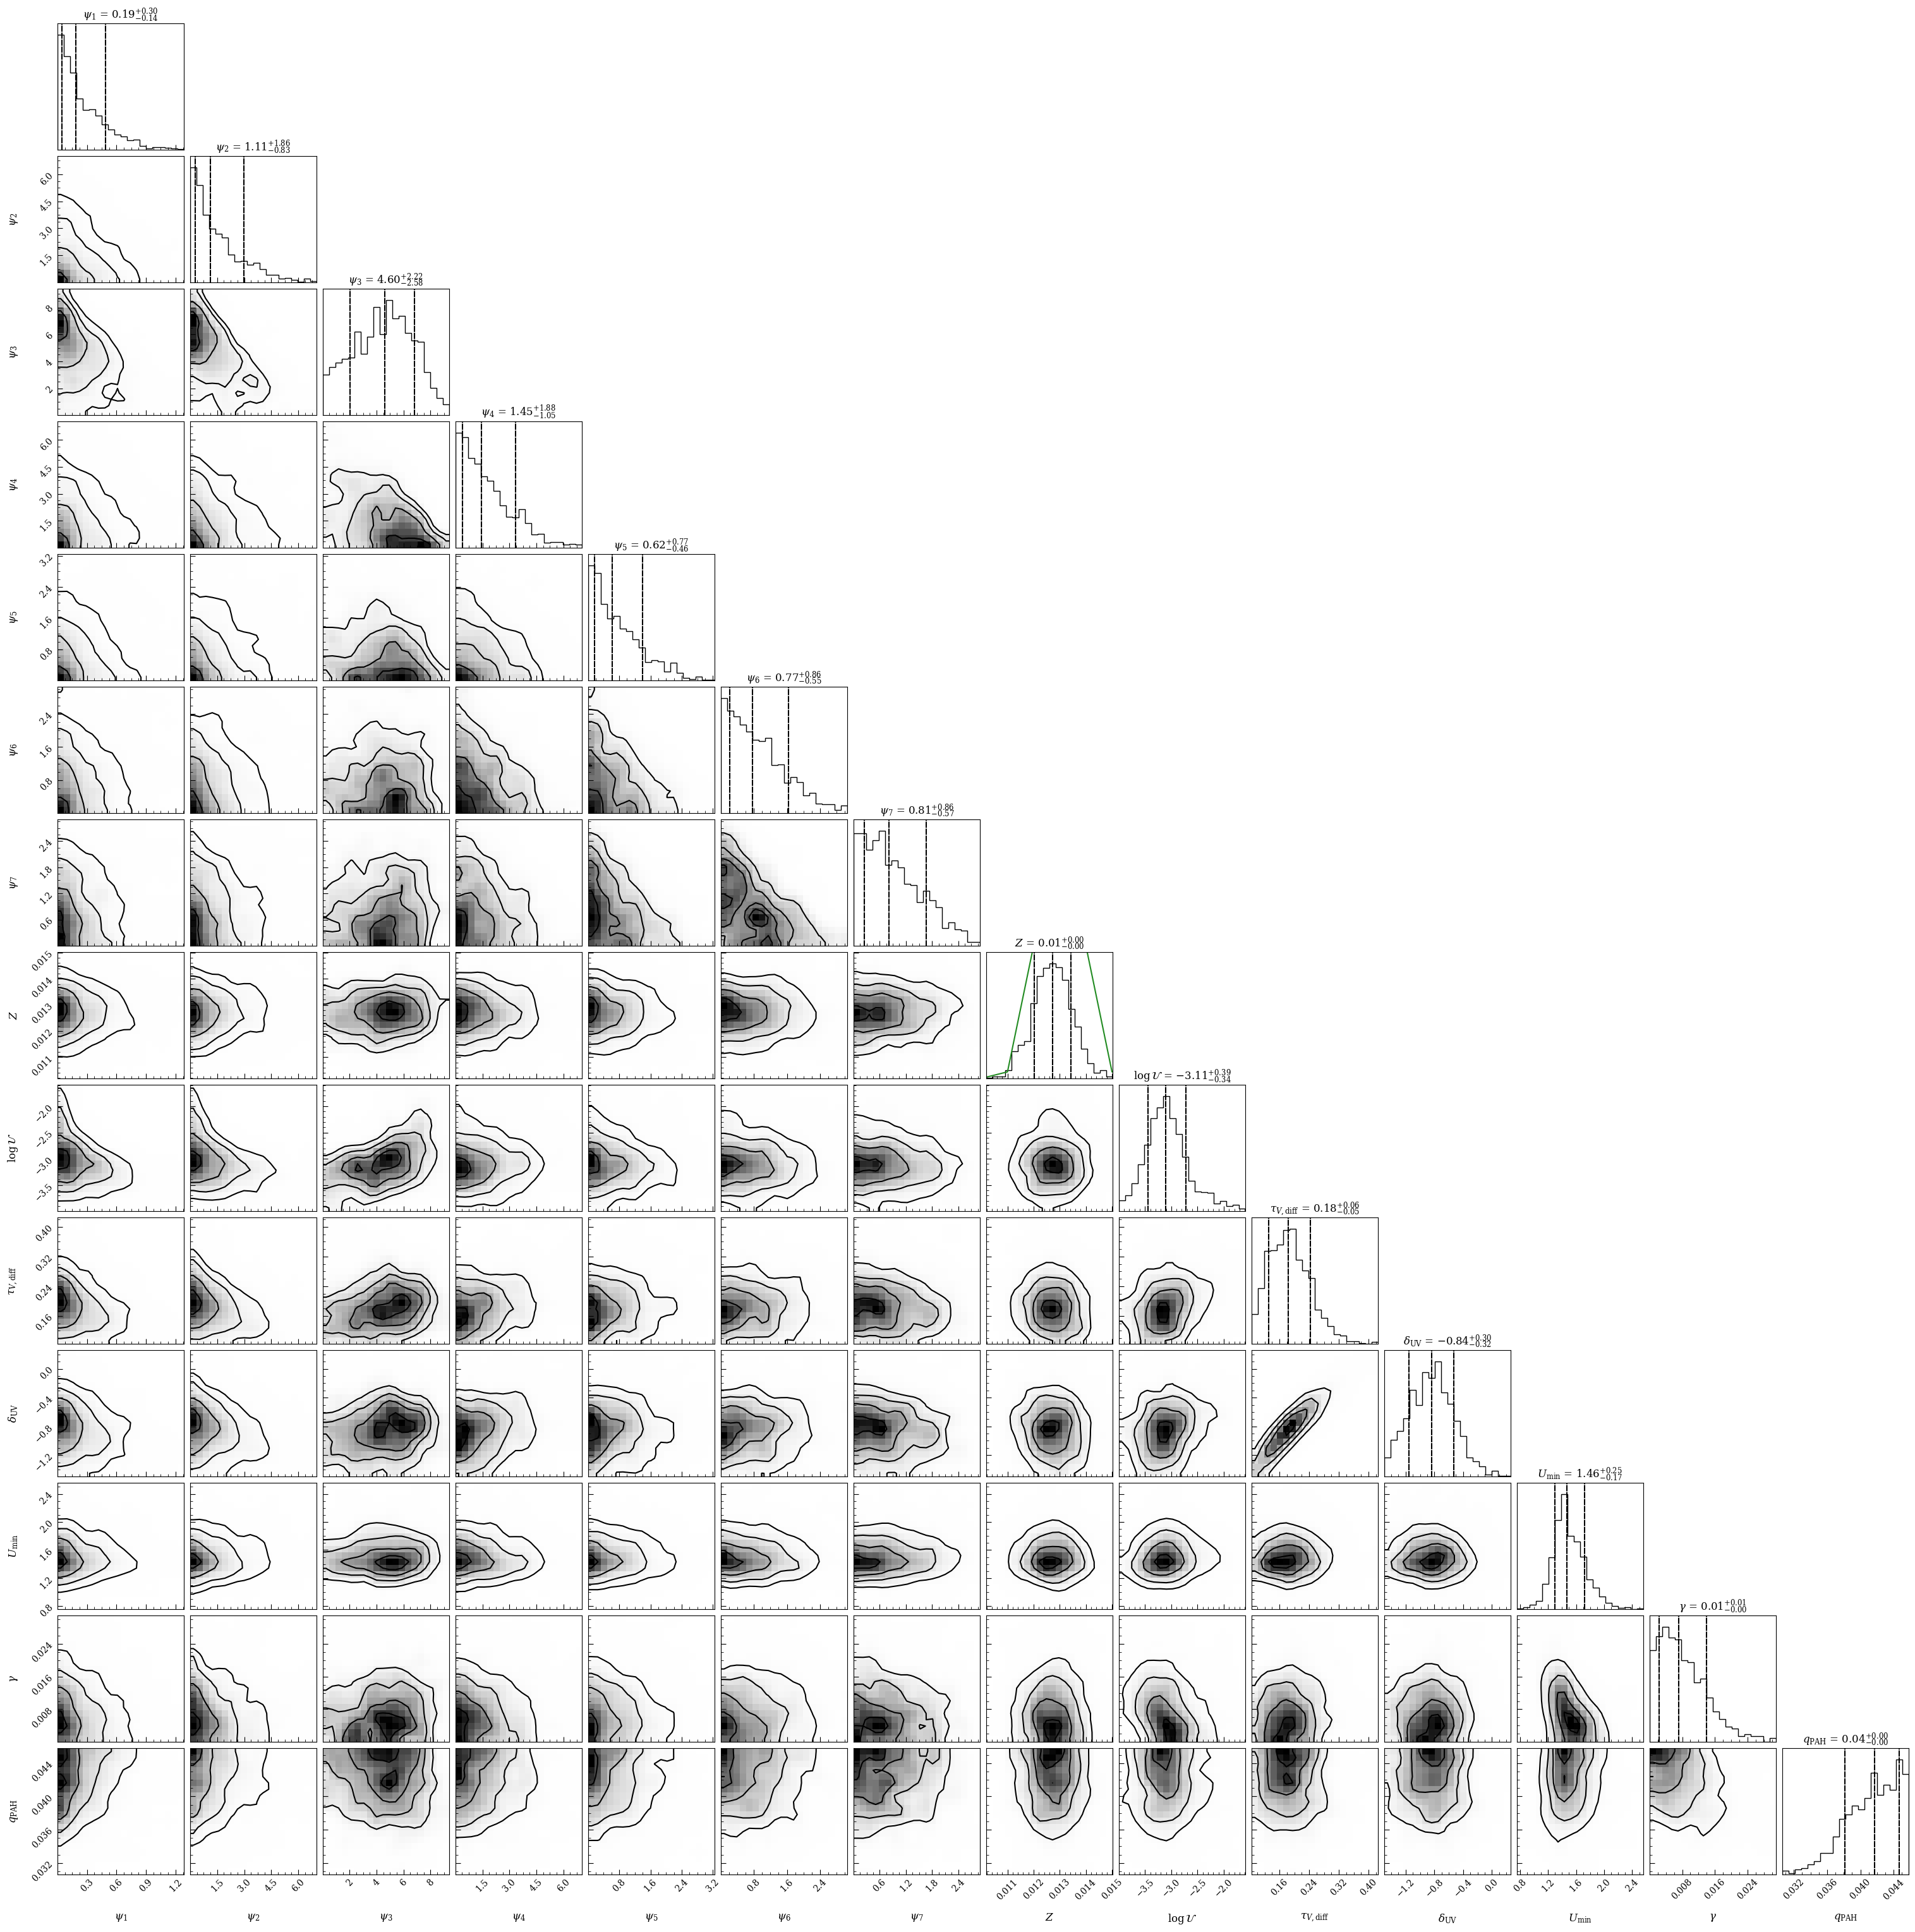

In [8]:
fig = lgh.corner_plot(chain, 
                      quantiles=(0.16, 0.50, 0.84),
                      smooth=1,
                      levels=None,
                      show_titles=True)

ZZ = np.linspace(0.001, 0.03, 30)
Zprior = lambda Z, mu, s: 1 / np.sqrt(2 * np.pi * s**2) * np.exp(-1 * (Z - mu)**2 / s**2)
axs = (np.array(fig.axes)).reshape(14,14)
yy = Zprior(ZZ, 0.013, 0.001)
axs[7,7].plot(ZZ, yy, color='forestgreen')

/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


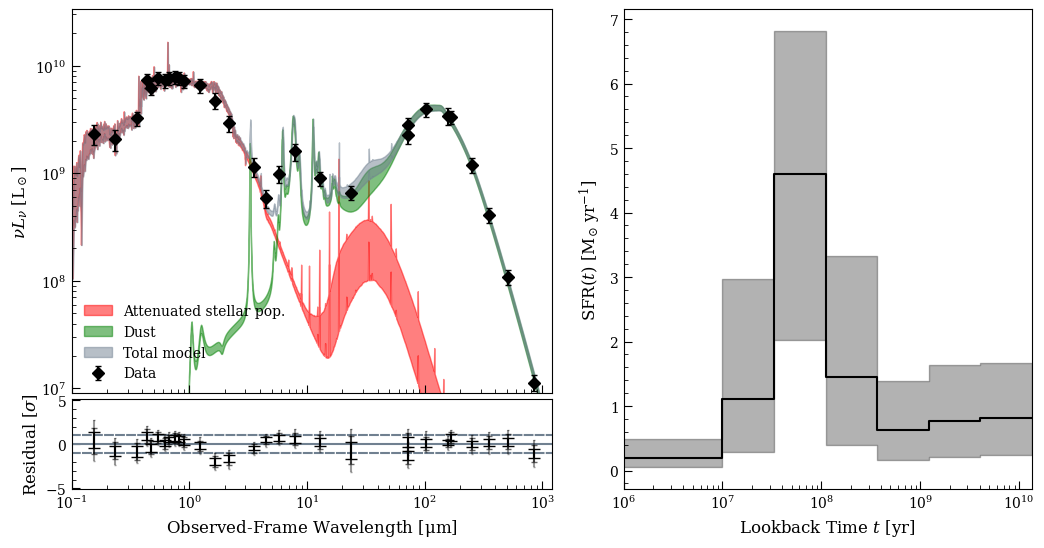

In [9]:
from lightning.plots import sed_plot_morebayesian, sed_plot_delchi_morebayesian, sfh_plot

fig5 = plt.figure(figsize=(12,6))
ax51 = fig5.add_axes([0.1, 0.26, 0.4, 0.64])
ax52 = fig5.add_axes([0.1, 0.1, 0.4, 0.15])
ax53 = fig5.add_axes([0.56, 0.1, 0.34, 0.8])

fig5, ax51 = sed_plot_morebayesian(lgh, chain, logprob_chain,
                                   plot_components=True,
                                   ax=ax51,
                                   legend_kwargs={'loc': 'lower left', 'frameon': False})
ax51.set_xticklabels([])
fig5, ax52 = sed_plot_delchi_morebayesian(lgh, chain, logprob_chain, ax=ax52)
fig5, ax53 = lgh.sfh_plot(chain, ax=ax53)

## Goodness of Fit

/Users/eqm5663/Research/code/plightning/lightning/ppc.py:77: RuntimeWarning: invalid value encountered in divide
  chi2_rep = np.nansum((Lmod - Lmod_perturbed)**2 / total_unc2, axis=-1)


p = 0.944


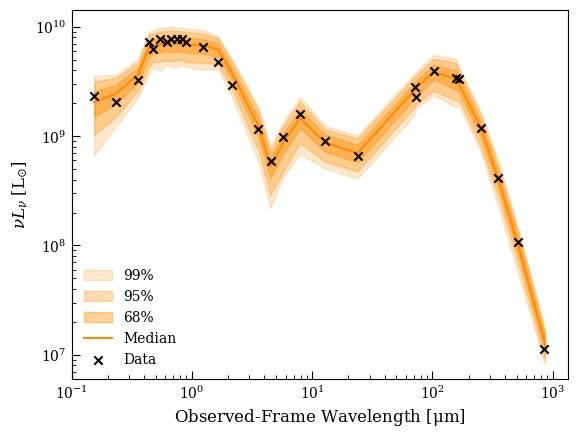

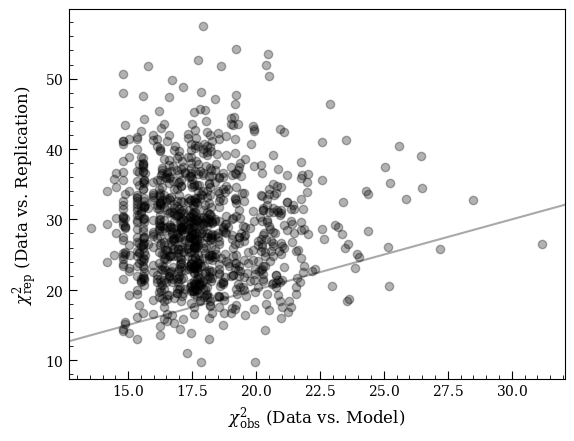

In [10]:
from lightning.ppc import ppc, ppc_sed
 
pvalue, chi2_rep, chi2_obs = ppc(lgh, chain,
                                 logprob_chain,
                                 Nrep=1000,
                                 seed=12345)
fig, ax = ppc_sed(lgh, chain,
                  logprob_chain,
                  Nrep=1000,
                  seed=12345,
                  normalize=False)

fig2, ax2 = plt.subplots()

ax2.scatter(chi2_obs,
            chi2_rep,
            marker='o',
            alpha=0.3)

xlim = ax2.get_xlim()
ax2.plot(xlim, xlim, linestyle='-', color='darkgray', zorder=-1)
ax2.set_xlim(xlim)

ax2.set_xlabel(r'$\chi_{\rm obs}^2$ (Data vs. Model)')
ax2.set_ylabel(r'$\chi_{\rm rep}^2$ (Data vs. Replication)')


print('p = %.3f' % (pvalue))

We're entering the realm of overfitting now, with $>90\%$ of Monte Carlo trials finding a worse result. This would suggest we need fewer SFH bins, or perhaps to hold $\log U$ constant.

## Line ratios

Now we'll have some fun. Even though we didn't fit the line ratios, we can extract the posteriors for the line ratios: the set of line ratios that are consistent with the broadband photometry given our model. We'll compare them to the nebular catalog of Groves+(2023) based on the PHANGS-MUSE survey.

/var/folders/p6/qlk1ytxd09vf64nrq0vfw06wgg_lcz/T/ipykernel_38318/4253786285.py:12: RuntimeWarning: divide by zero encountered in log10
  OIIIHbeta_obs = np.log10(neb['OIII5006_FLUX_CORR'] / neb['HB4861_FLUX_CORR'])
/var/folders/p6/qlk1ytxd09vf64nrq0vfw06wgg_lcz/T/ipykernel_38318/4253786285.py:15: RuntimeWarning: divide by zero encountered in log10
  OIHalpha_obs = np.log10(neb['OI6300_FLUX_CORR'] / neb['HA6562_FLUX_CORR'])
/Users/eqm5663/Research/code/plightning/lightning/stellar/bpass.py:1409: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.transpose(self.line_lum, axes=[1,2,0,3])),


Text(0.5, 0, '$\\rm \\log([O I] / H\\alpha)$')

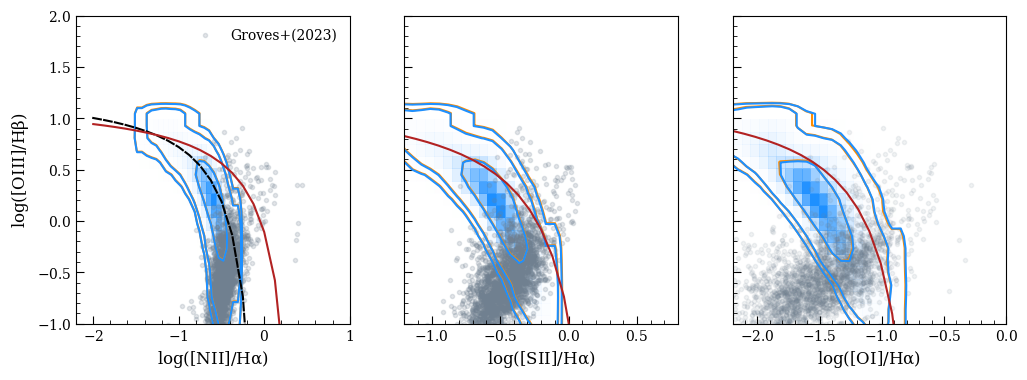

In [12]:
import corner

# Convenience functions to plot BPT-like diagnostic regions
from lightning.plots import k06_NIIplot, k06_SIIplot, k06_OIplot

from astropy.table import Table

# Line measurements from Groves+(2023) for 2855 individual nebulae
# in NGC 628.
neb = Table.read('../photometry/NGC628_nebula_catalog.fits')

OIIIHbeta_obs = np.log10(neb['OIII5006_FLUX_CORR'] / neb['HB4861_FLUX_CORR'])
NIIHalpha_obs = np.log10(neb['NII6583_FLUX_CORR'] / neb['HA6562_FLUX_CORR'])
SIIHalpha_obs = np.log10((neb['SII6716_FLUX_CORR'] + neb['SII6730_FLUX_CORR']) / neb['HA6562_FLUX_CORR'])
OIHalpha_obs = np.log10(neb['OI6300_FLUX_CORR'] / neb['HA6562_FLUX_CORR'])

linelum, linelum_intr = lgh.get_model_lines(chain)

OIIImask = lgh.stars.line_labels == 'O__3_500684A'
Halphamask = lgh.stars.line_labels == 'H__1_656280A'
Hbetamask = lgh.stars.line_labels == 'H__1_486132A'
NIImask = lgh.stars.line_labels == 'N__2_658345A'
SII6717mask = lgh.stars.line_labels == 'S__2_671644A'
SII6730mask = lgh.stars.line_labels == 'S__2_673082A'
OImask = lgh.stars.line_labels == 'BLND_630000A'

OIIIHbeta = np.log10(linelum[:,OIIImask] / linelum[:,Hbetamask])
NIIHalpha = np.log10(linelum[:,NIImask] / linelum[:,Halphamask])
SIIHalpha = np.log10((linelum[:,SII6717mask] + linelum[:,SII6730mask]) / linelum[:,Halphamask])
OIHalpha = np.log10(linelum[:,OImask] / linelum[:,Halphamask])

OIIIHbeta_intr = np.log10(linelum_intr[:,OIIImask] / linelum_intr[:,Hbetamask])
NIIHalpha_intr = np.log10(linelum_intr[:,NIImask] / linelum_intr[:,Halphamask])
SIIHalpha_intr = np.log10((linelum_intr[:,SII6717mask] + linelum_intr[:,SII6730mask]) / linelum_intr[:,Halphamask])
OIHalpha_intr = np.log10(linelum_intr[:,OImask] / linelum_intr[:,Halphamask])

fig, axs = plt.subplots(1,3, figsize=(12,4))

corner.hist2d(NIIHalpha, OIIIHbeta, smooth=1, color='darkorange', levels=[0.50, 0.95, 0.99], ax=axs[0])
corner.hist2d(NIIHalpha_intr, OIIIHbeta_intr, smooth=1, color='dodgerblue', levels=[0.50, 0.95, 0.99], ax=axs[0])
k06_NIIplot(ax=axs[0])
axs[0].scatter(NIIHalpha_obs, OIIIHbeta_obs, marker='.', color='slategray', alpha=0.2, label='Groves+(2023)')

axs[0].set_xlim(-2.2,1)
axs[0].set_ylim(-1,2)
axs[0].set_xlabel(r'$\rm \log([N II] / H\alpha)$')
axs[0].set_ylabel(r'$\rm \log([O III] / H\beta)$')
axs[0].legend(loc='best')

corner.hist2d(SIIHalpha, OIIIHbeta, smooth=1, color='darkorange', levels=[0.50, 0.95, 0.99], ax=axs[1])
corner.hist2d(SIIHalpha_intr, OIIIHbeta_intr, smooth=1, color='dodgerblue', levels=[0.50, 0.95, 0.99], ax=axs[1])
axs[1].scatter(SIIHalpha_obs, OIIIHbeta_obs, marker='.', color='slategray', alpha=0.2)
k06_SIIplot(ax=axs[1])
axs[1].set_xlim(-1.2,0.8)
axs[1].set_ylim(-1,2)
axs[1].set_yticklabels([])
axs[1].set_xlabel(r'$\rm \log([S II] / H\alpha)$')

corner.hist2d(OIHalpha, OIIIHbeta, smooth=1, color='darkorange', levels=[0.50, 0.95, 0.99], ax=axs[2])
corner.hist2d(OIHalpha_intr, OIIIHbeta_intr, smooth=1, color='dodgerblue', levels=[0.50, 0.95, 0.99], ax=axs[2])
axs[2].scatter(OIHalpha_obs, OIIIHbeta_obs, marker='.', color='slategray', alpha=0.1)
k06_OIplot(ax=axs[2])
axs[2].set_xlim(-2.2,0.0)
axs[2].set_ylim(-1,2)
axs[2].set_yticklabels([])
axs[2].set_xlabel(r'$\rm \log([O I] / H\alpha)$')

The excellent agreement of the $\rm [NII] / H\alpha$ posterior isn't that surprising, given the narrow posterior we placed on the metallicity was drawn from these same data. In a subsequent notebook we'll fit the line ratios directly.

## New PEGASE models

We repeat the fitting and analysis above with the new PEGASE models. We compare the stellar models in more detail in a different notebook.

In [13]:
cat = Table.read('../photometry/ngc628_dale17_photometry.fits')

filter_labels = np.array([s.decode().strip() for s in cat['FILTER_LABELS'].data[0]])
fnu_obs = cat['FNU_OBS'].data[0]
fnu_unc = cat['FNU_UNC'].data[0]
dl = cat['LUMIN_DIST'].data[0]


agebins = [0.0] + list(np.logspace(7, np.log10(13.4e9), 7))

lgh = Lightning(filter_labels, 
                lum_dist=dl, 
                ages=agebins,
                nebula_lognH=3.5,
                nebula_dust=True,
                stellar_type='PEGASE-A24',
                SFH_type='Piecewise-Constant',
                atten_type='Modified-Calzetti',
                dust_emission=True,
                model_unc=0.10,
                print_setup_time=True)


lgh.flux_obs = fnu_obs * 1e3
lgh.flux_unc = fnu_unc * 1e3

# lgh.save_pickle('ngc628_PEGASE_config.pkl')

0.025 s elapsed in _get_filters
0.000 s elapsed in _get_wave_obs
1.617 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
0.130 s elapsed in dust emission model setup
0.000 s elapsed in agn emission model setup
0.000 s elapsed in X-ray model setup
1.773 s elapsed total


In [14]:
lgh.print_params(verbose=True)


Piecewise-Constant
Parameter  Lo  Hi              Description
--------- --- --- ------------------------
    psi_1 0.0 inf SFR in stellar age bin 1
    psi_2 0.0 inf SFR in stellar age bin 2
    psi_3 0.0 inf SFR in stellar age bin 3
    psi_4 0.0 inf SFR in stellar age bin 4
    psi_5 0.0 inf SFR in stellar age bin 5
    psi_6 0.0 inf SFR in stellar age bin 6
    psi_7 0.0 inf SFR in stellar age bin 7

PEGASE-Stellar-A24
Parameter                    Lo                 Hi                                                   Description
--------- --------------------- ------------------ -------------------------------------------------------------
     Zmet 0.0006471873203208087 0.0257649912911017 Metallicity (mass fraction, where solar = 0.020 ~ 10**[-1.7])
     logU                  -4.0               -1.5                             log10 of the ionization parameter

Modified-Calzetti
      Parameter   Lo                 Hi                                                               

In [15]:
p0_seed = np.array([5,5,5,0,0,0,0,
                    0.014, -2.0,
                    0.1, -1.0, 0.0,
                    2, 3, 3e5, 0.01, 0.02])

priors = 7 * [UniformPrior([0,20])] + \
             [NormalPrior([0.013, 0.001]), NormalPrior([-2.5,0.75])] + \
             [UniformPrior([0,3]), UniformPrior([-1.5, 0.3]), None] + \
             [ConstantPrior([2]), UniformPrior([0.1, 25]), ConstantPrior([3e5]), UniformPrior([0,1]), UniformPrior([0.0047, 0.0458])]
const_dim = 7 * [False] + \
            [False, False] + \
            [False, False, True] + \
            [True, False, True, False, False]
const_dim = np.array(const_dim)
const_vals = p0_seed[const_dim]

Nwalkers = 64

p0s = [pr.sample(Nwalkers) if pr is not None else np.zeros(Nwalkers) for pr in priors]
p0 = np.stack(p0s, axis=-1)
# p0[:, const_dim] = const_vals[None,:]

# Metallicity and logU might sample out of bounds
p0[p0[:,7] < 0.001, 7] = 0.001
p0[p0[:,7] > 0.02, 7] = 0.02
p0[p0[:,8] < -3, 8] = -3
p0[p0[:,8] > -1.5, 8] = -1.5

mcmc = lgh.fit(p0,
               method='emcee',
               priors=priors,
               const_dim=const_dim,
               Nwalkers=Nwalkers,
               Nsteps=30000,
               progress=True)

# mcmc = l.fit(p0, method='emcee', Nwalkers=Nwalkers, Nsteps=20000, priors=priors, const_dim=const_dim)
# print(res_bp)

/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:1070: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.transpose(self.Lnu_obs, axes=[1,2,0,3])),
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/scipy/interpolate/_rgi.py:418: RuntimeWarning: invalid value encountered in multiply
  term = np.asarray(self.values[edge_indices]) * weight[vslice]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [15:35<00:00, 32.06it/s]


In [16]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc.acceptance_fraction)))

MCMC mean acceptance fraction: 0.208


In [17]:
chain, logprob_chain, tau_ac = lgh.get_mcmc_chains(mcmc, discard=2000, thin=500, const_dim=const_dim, const_vals=p0_seed[const_dim])

         The autocorrelation estimate may be unreliable.


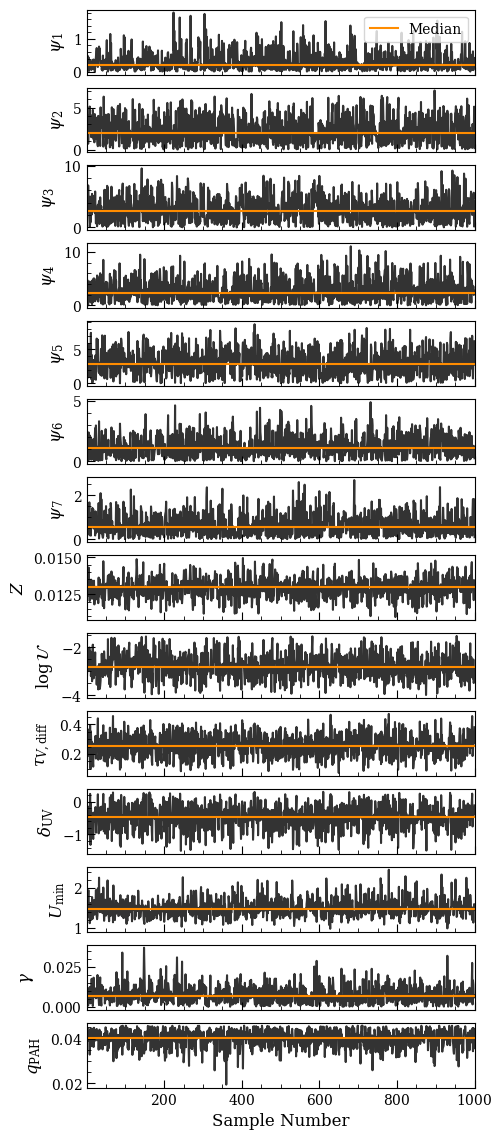

In [18]:
fig, axs = lgh.chain_plot(chain, color='k', alpha=0.8)

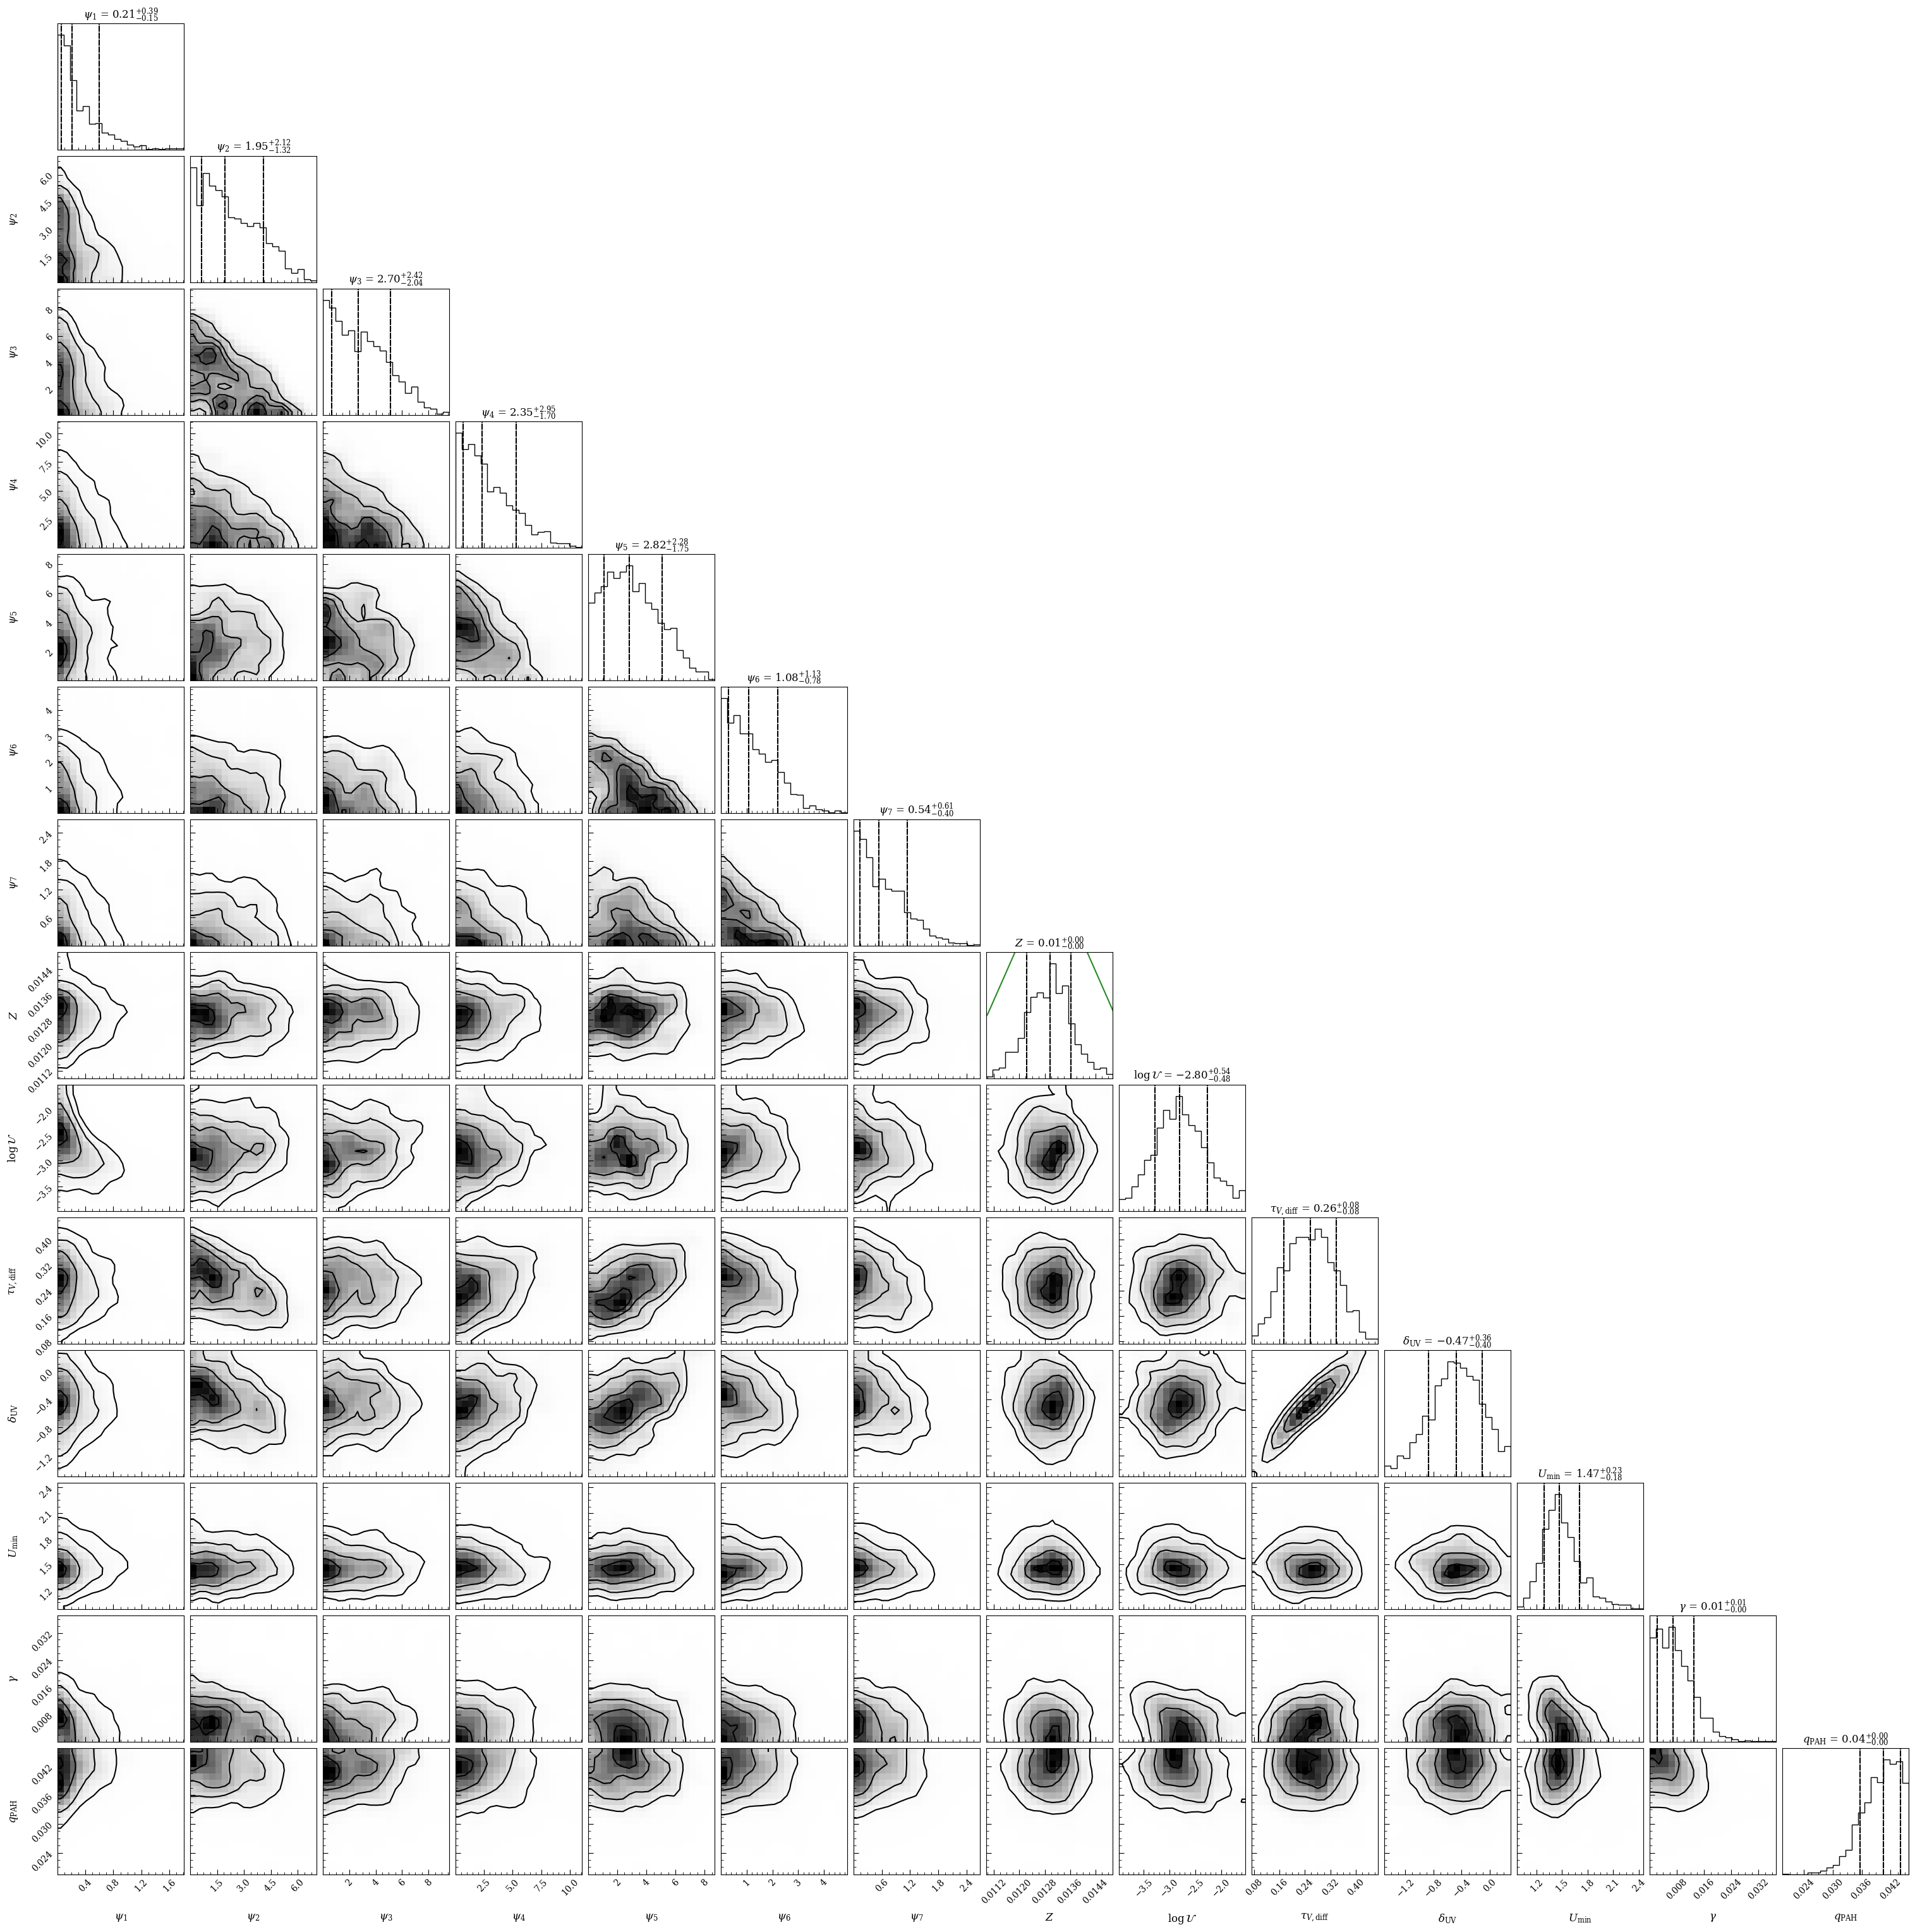

In [19]:
fig = lgh.corner_plot(chain, 
                      quantiles=(0.16, 0.50, 0.84),
                      smooth=1,
                      levels=None,
                      show_titles=True)

ZZ = np.linspace(0.001, 0.03, 30)
Zprior = lambda Z, mu, s: 1 / np.sqrt(2 * np.pi * s**2) * np.exp(-1 * (Z - mu)**2 / s**2)
axs = (np.array(fig.axes)).reshape(14,14)
yy = Zprior(ZZ, 0.013, 0.002)
axs[7,7].plot(ZZ, yy, color='forestgreen')

/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:1070: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.transpose(self.Lnu_obs, axes=[1,2,0,3])),
/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:1070: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.transpose(self.Lnu_obs, axes=[1,2,0,3])),
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


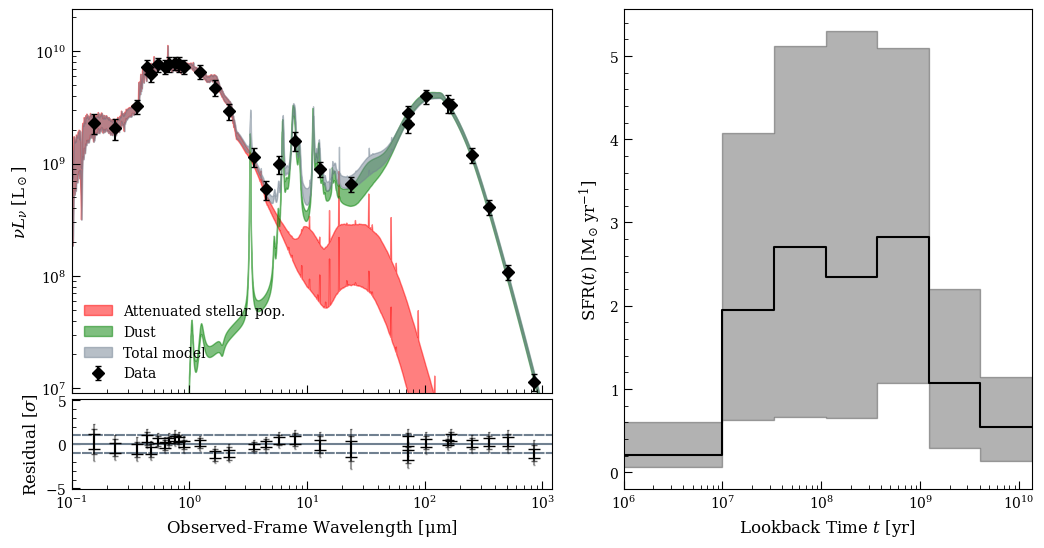

In [20]:
from lightning.plots import sed_plot_morebayesian, sed_plot_delchi_morebayesian, sfh_plot

fig5 = plt.figure(figsize=(12,6))
ax51 = fig5.add_axes([0.1, 0.26, 0.4, 0.64])
ax52 = fig5.add_axes([0.1, 0.1, 0.4, 0.15])
ax53 = fig5.add_axes([0.56, 0.1, 0.34, 0.8])

fig5, ax51 = sed_plot_morebayesian(lgh, chain, logprob_chain,
                                   plot_components=True,
                                   ax=ax51,
                                   legend_kwargs={'loc': 'lower left', 'frameon': False})
ax51.set_xticklabels([])
fig5, ax52 = sed_plot_delchi_morebayesian(lgh, chain, logprob_chain, ax=ax52)
fig5, ax53 = lgh.sfh_plot(chain, ax=ax53)

/Users/eqm5663/Research/code/plightning/lightning/ppc.py:77: RuntimeWarning: invalid value encountered in divide
  chi2_rep = np.nansum((Lmod - Lmod_perturbed)**2 / total_unc2, axis=-1)


p = 0.997


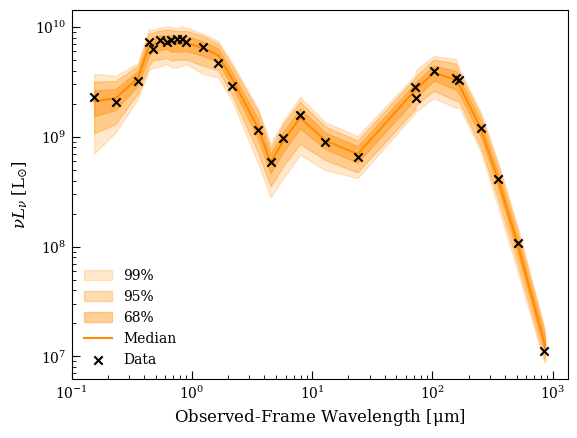

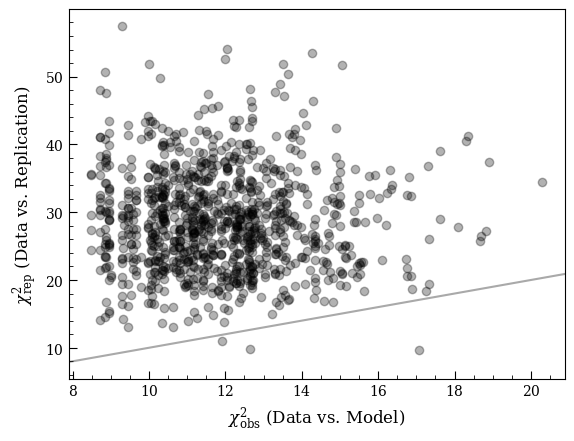

In [21]:
from lightning.ppc import ppc, ppc_sed

pvalue, chi2_rep, chi2_obs = ppc(lgh, chain,
                                 logprob_chain,
                                 Nrep=1000,
                                 seed=12345)
fig, ax = ppc_sed(lgh, chain,
                  logprob_chain,
                  Nrep=1000,
                  seed=12345,
                  normalize=False)

fig2, ax2 = plt.subplots()

ax2.scatter(chi2_obs,
            chi2_rep,
            marker='o',
            alpha=0.3)

xlim = ax2.get_xlim()
ax2.plot(xlim, xlim, linestyle='-', color='darkgray', zorder=-1)
ax2.set_xlim(xlim)

ax2.set_xlabel(r'$\chi_{\rm obs}^2$ (Data vs. Model)')
ax2.set_ylabel(r'$\chi_{\rm rep}^2$ (Data vs. Replication)')


print('p = %.3f' % (pvalue))

Now we're really overfitting.

/var/folders/p6/qlk1ytxd09vf64nrq0vfw06wgg_lcz/T/ipykernel_38318/2227680488.py:11: RuntimeWarning: divide by zero encountered in log10
  OIIIHbeta_obs = np.log10(neb['OIII5006_FLUX_CORR'] / neb['HB4861_FLUX_CORR'])
/var/folders/p6/qlk1ytxd09vf64nrq0vfw06wgg_lcz/T/ipykernel_38318/2227680488.py:14: RuntimeWarning: divide by zero encountered in log10
  OIHalpha_obs = np.log10(neb['OI6300_FLUX_CORR'] / neb['HA6562_FLUX_CORR'])
/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:1278: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.transpose(self.line_lum, axes=[1,2,0,3])),


Text(0.5, 0, '$\\rm \\log([O I] / H\\alpha)$')

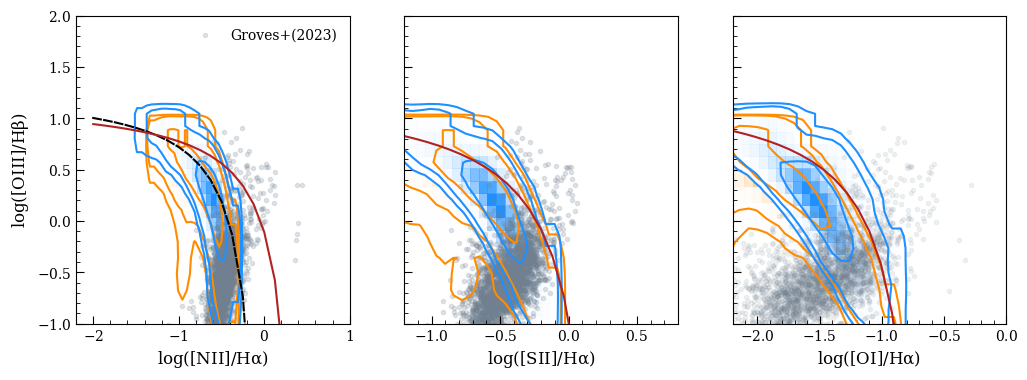

In [22]:
import corner
# Convenience functions I made to plot BPT-like diagnostic regions
from lightning.plots import k06_NIIplot, k06_SIIplot, k06_OIplot

from astropy.table import Table

# Line measurements from Groves+(2023) for 2855 individual nebulae
# in NGC 628.
neb = Table.read('../photometry/NGC628_nebula_catalog.fits')

OIIIHbeta_obs = np.log10(neb['OIII5006_FLUX_CORR'] / neb['HB4861_FLUX_CORR'])
NIIHalpha_obs = np.log10(neb['NII6583_FLUX_CORR'] / neb['HA6562_FLUX_CORR'])
SIIHalpha_obs = np.log10((neb['SII6716_FLUX_CORR'] + neb['SII6730_FLUX_CORR']) / neb['HA6562_FLUX_CORR'])
OIHalpha_obs = np.log10(neb['OI6300_FLUX_CORR'] / neb['HA6562_FLUX_CORR'])

linelum, linelum_intr = lgh.get_model_lines(chain)

OIIImask = lgh.stars.line_labels == 'O__3_500684A'
Halphamask = lgh.stars.line_labels == 'H__1_656280A'
Hbetamask = lgh.stars.line_labels == 'H__1_486132A'
NIImask = lgh.stars.line_labels == 'N__2_658345A'
SII6717mask = lgh.stars.line_labels == 'S__2_671644A'
SII6730mask = lgh.stars.line_labels == 'S__2_673082A'
OImask = lgh.stars.line_labels == 'BLND_630000A'

OIIIHbeta = np.log10(linelum[:,OIIImask] / linelum[:,Hbetamask])
NIIHalpha = np.log10(linelum[:,NIImask] / linelum[:,Halphamask])
SIIHalpha = np.log10((linelum[:,SII6717mask] + linelum[:,SII6730mask]) / linelum[:,Halphamask])
OIHalpha = np.log10(linelum[:,OImask] / linelum[:,Halphamask])

OIIIHbeta = np.log10(linelum_intr[:,OIIImask] / linelum_intr[:,Hbetamask])
NIIHalpha = np.log10(linelum_intr[:,NIImask] / linelum_intr[:,Halphamask])
SIIHalpha = np.log10((linelum_intr[:,SII6717mask] + linelum_intr[:,SII6730mask]) / linelum_intr[:,Halphamask])
OIHalpha = np.log10(linelum_intr[:,OImask] / linelum_intr[:,Halphamask])

fig, axs = plt.subplots(1,3, figsize=(12,4))

corner.hist2d(NIIHalpha, OIIIHbeta, smooth=1, color='darkorange', levels=[0.50, 0.95, 0.99], ax=axs[0])
corner.hist2d(NIIHalpha_intr, OIIIHbeta_intr, smooth=1, color='dodgerblue', levels=[0.50, 0.95, 0.99], ax=axs[0])
k06_NIIplot(ax=axs[0])
axs[0].scatter(NIIHalpha_obs, OIIIHbeta_obs, marker='.', color='slategray', alpha=0.2, label='Groves+(2023)')

axs[0].set_xlim(-2.2,1)
axs[0].set_ylim(-1,2)
axs[0].set_xlabel(r'$\rm \log([N II] / H\alpha)$')
axs[0].set_ylabel(r'$\rm \log([O III] / H\beta)$')
axs[0].legend(loc='best')

corner.hist2d(SIIHalpha, OIIIHbeta, smooth=1, color='darkorange', levels=[0.50, 0.95, 0.99], ax=axs[1])
corner.hist2d(SIIHalpha_intr, OIIIHbeta_intr, smooth=1, color='dodgerblue', levels=[0.50, 0.95, 0.99], ax=axs[1])
axs[1].scatter(SIIHalpha_obs, OIIIHbeta_obs, marker='.', color='slategray', alpha=0.2)
k06_SIIplot(ax=axs[1])
axs[1].set_xlim(-1.2,0.8)
axs[1].set_ylim(-1,2)
axs[1].set_yticklabels([])
axs[1].set_xlabel(r'$\rm \log([S II] / H\alpha)$')

corner.hist2d(OIHalpha, OIIIHbeta, smooth=1, color='darkorange', levels=[0.50, 0.95, 0.99], ax=axs[2])
corner.hist2d(OIHalpha_intr, OIIIHbeta_intr, smooth=1, color='dodgerblue', levels=[0.50, 0.95, 0.99], ax=axs[2])
axs[2].scatter(OIHalpha_obs, OIIIHbeta_obs, marker='.', color='slategray', alpha=0.1)
k06_OIplot(ax=axs[2])
axs[2].set_xlim(-2.2,0.0)
axs[2].set_ylim(-1,2)
axs[2].set_yticklabels([])
axs[2].set_xlabel(r'$\rm \log([O I] / H\alpha)$')

The orange contours represent the redenned line ratios, while the blue are intrinsic. The BPASS solution is consistently less attenuated than the PEGASE solution (the BPASS stellar population models are actually just redder, seemingly due to an over-production of AGB stars) so the difference in line ratios is less obvious there. We should be looking for agreement between the blue contour and the background points, which we see again is generally ok, especially where our choice of prior makes it so in $\rm [N II] / H\alpha$.